# NCorr-FP: POC

Neighbourhood-based fingerprinting for correlated data is a method of embedding a traceable mark into the tabular data and is unlike its predecessors data driven, meaning that it preserves the existing stats of the data.

This notebook represents the proof-of-concept and preliminary analysis of the method, its effectiveness, fidelity, robustness and effects on data utility. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# todo: move plotting functions to a script 

In [2]:
# Markers
markers = ['o', 'v', 'x', 's']

In [3]:
results = pd.read_csv('effectiveness-covertype-sample.csv')
results.head(2)

,gamma,k,fingerprint_length,n_recipients,sk,embedding_ratio,vote_error,tp,tn
0,2,300,64,20,100,0.5,0.023075,1.0,0.5
1,2,300,64,20,100,0.5,0.023075,1.0,0.5


## Effectiveness

The fisrt requirements of the fingerprinting method is its effectiveness. 
To that end, we measure:
1. Detection error rates (rate of wrong votes)
2. Detection rate (number of bits correctly extracted)

This depends on the numbed of marked records and neighbourhood size.

### 1. Vote errors
To recap from the demo, some detection errors are made due to slight shift in data distributions in fingerprinted dataset. We quantify these errors depending on neighbourhood size and number of embedded marks.

Hypohteses:
- small neighbourhood size causes more detection errors bacuse the distributions might not be representative; too big neighbourhood might have some copmputational cost and not presrve the correlations as well
- the more marks embedded, the more errors introduced

In [4]:
# insert vote errors on forest cover data

# x-axis: gamma
# y-axis: vote error rate
# colors: neighbourhood size
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fix: fp_length (128), n_recipients (20), recipient_id (0) b

In [5]:
def plot_vote_error_rate(results):
    """
    Plots the vote error rate with standard deviation shading for different neighborhood sizes.

    Args:
    - results (pd.DataFrame): DataFrame containing 'embedding_ratio', 'vote error rate', and 'neighbourhood size' columns.
    """
    # Group by 'gamma' and 'neighbourhood size' to calculate mean and standard deviation
    grouped_data = results.groupby(['embedding_ratio', 'k'])['vote_error'].agg(['mean', 'std']).reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))

    # Iterate through each neighborhood size for separate lines and shaded areas
    for i, neighborhood_size in enumerate(grouped_data['k'].unique()):
        # Filter data for the current neighborhood size
        data = grouped_data[grouped_data['k'] == neighborhood_size]
        
        # Plot line for average vote error rate
        plt.plot(data['embedding_ratio'], data['mean'], label=f'{neighborhood_size} / {round(100*neighborhood_size/30000, 2)}%', 
                 marker=markers[i])
        
        # Plot shaded area for standard deviation
        plt.fill_between(data['embedding_ratio'], data['mean'] - data['std'], data['mean'] + data['std'], alpha=0.2)
        
    # Plot the ideal scenario for comparison
    # plt.plot(data['embedding_ratio'], [0.0 for i in range(len(data['embedding_ratio']))], linestyle=(0, (5,10)), linewidth=1.4, 
    #         label=f'Ideal scenario')
    
    # plt.ylim(0, 1)
    # Labels and legend
    plt.xlabel('Fingerprint embedding ratio (1/gamma) [0, 1]')
    plt.ylabel('Vote Error Rate [0, 1]')
    plt.title('Vote Error Rate vs Fingerprint embedding ratio with Neighborhood Size')
    plt.legend(title='Neighborhood Size\n(#records / %data size)')
    plt.grid(True)
    plt.show()

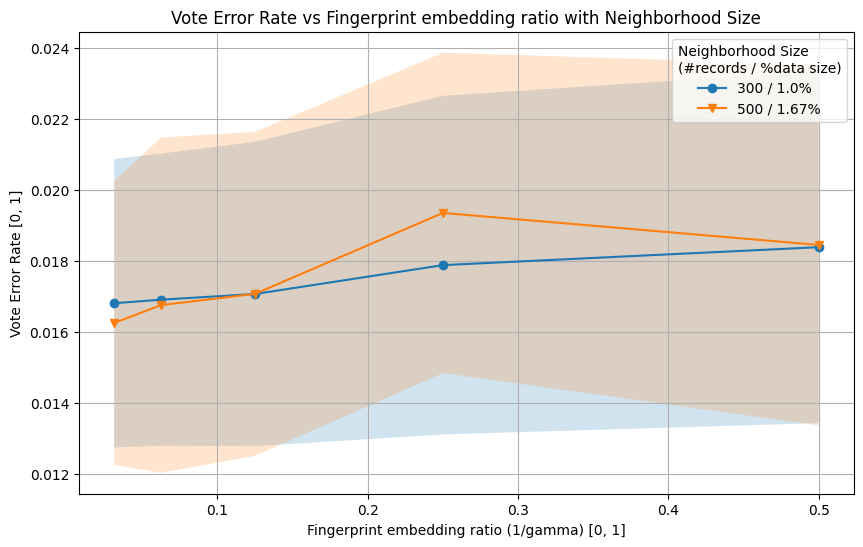

In [6]:
# Generate the plot
plot_vote_error_rate(results)

### 2. Fingerprint bit errors (Correct fingerprint confidence)

This measure depicts more closely the actual extraction success for the fingerprint. Normally, we would want a 100% extraction ratio, i.e. all bits are correctly extracted, however, a high percentage associated to a fingerprint of one recipient might be indicator enough for the correct recipient, especially if the rate is low for other recipients (i.e. around 50% for random guessing).
The extraction provides a probability vector for each recipient; we measure the probability for the correct fingerprint. In the next point, we look at extraction rate for true negatives.

Hypotheses:
- fingerprint bit length  
- number of marks embedded

Experiment:
- 10 fingerprint embeddings
- 10 different gammas
- 3 different fingerprint lengths

In [7]:
# insert fingerprint bit errors (correct fingerprint confidence)

# x-axis: gamma
# y-axis: correct fingerprint confidence
# color: fingerprint lenght
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fix_ k (300), n_recipients (20), recipient_id (0) 

In [8]:
def plot_tp_confidence(results):
    """
    Plots the confidence rate for matching the correct recipient with standard deviation shading for different FP lengths.

    Args:
    - results (pd.DataFrame): DataFrame containing 'embedding_ratio', 'tp', and 'fingerprint_length' columns.
    """
    # Group by 'embedding_ratio' and 'fingerprint length' to calculate mean and standard deviation
    grouped_data = results.groupby(['embedding_ratio', 'fingerprint_length'])['tp'].agg(['mean', 'std']).reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))

    # Iterate through each neighborhood size for separate lines and shaded areas
    for i, fingerprint_length in enumerate(grouped_data['fingerprint_length'].unique()):
        # Filter data for the current neighborhood size
        data = grouped_data[grouped_data['fingerprint_length'] == fingerprint_length]
        
        # Plot line for average vote error rate
        plt.plot(data['embedding_ratio'], data['mean'], label=f'{fingerprint_length}-bit', marker=markers[i])
        
        # Plot shaded area for standard deviation
        plt.fill_between(data['embedding_ratio'], data['mean'] - data['std'], data['mean'] + data['std'], alpha=0.2)
    
    # Labels and legend
    plt.xlabel('Fingerprint embedding ratio (1/gamma) [0, 1]')
    plt.ylabel('Correct extraction confidence [0, 1]')
    plt.title('Correct extraction confidence')
    plt.legend(title='Fingerprint Length (in bits)')
    plt.grid(True)
    plt.show()

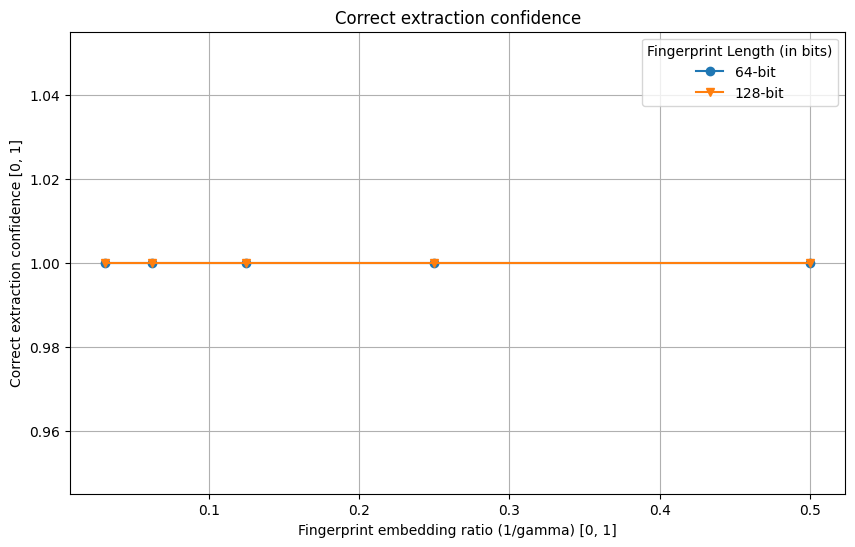

In [9]:
plot_tp_confidence(results)

### 3. True negatives

Here we look at how the probabilities look like for wrong recipients. In every fingerprint detection, the algorithm outputs confidences for all recipients. In ideal scenario, the confidence of the correct recipient is 1.0 (i.e. perfect bit-wise matching of a detected fingerprint to the fingerprint of the correct recipient), and the confidences of all orther recipients are around 0.5, in line with random guessing of the bit-sequence.

Experiment (same as above):
- fixed: 10 recipients
- 20 fingerprint embeddings
- 10 different gammas
- 3 different fingerprint lengths

In [10]:
# insert true negatives confidence

# x-axis: gamma 
# y-axis: false fingerprint confidence (this is the confidence that gets assigned to the wrong recipient)
# color: fingerprint lenght
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fix_ k (300), n_recipients (20), recipient_id (0) 

In [11]:
def plot_tn_confidence(results):
    """
    Plots the confidence rate for matching the wrong recipient with standard deviation shading for different FP lengths.

    Args:
    - results (pd.DataFrame): DataFrame containing 'embedding_ratio', 'tn', and 'fingerprint_length' columns.
    """
    # Group by 'embedding_ratio' and 'fingerprint length' to calculate mean and standard deviation
    grouped_data = results.groupby(['embedding_ratio', 'fingerprint_length'])['tn'].agg(['mean', 'std']).reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))

    # Iterate through each neighborhood size for separate lines and shaded areas
    for i, fingerprint_length in enumerate(grouped_data['fingerprint_length'].unique()):
        # Filter data for the current neighborhood size
        data = grouped_data[grouped_data['fingerprint_length'] == fingerprint_length]
        
        # Plot line for average vote error rate
        plt.plot(data['embedding_ratio'], data['mean'], label=f'{fingerprint_length}-bit', marker=markers[i])
        
        # Plot shaded area for standard deviation
        plt.fill_between(data['embedding_ratio'], data['mean'] - data['std'], data['mean'] + data['std'], alpha=0.2)
    
    # Labels and legend
    plt.xlabel('Fingerprint embedding ratio (1/gamma) [0, 1]')
    plt.ylabel('Wrong extraction confidence [0, 1]')
    plt.title('Wrong extraction confidence')
    plt.legend(title='Fingerprint Length (in bits)')
    plt.grid(True)
    plt.show()

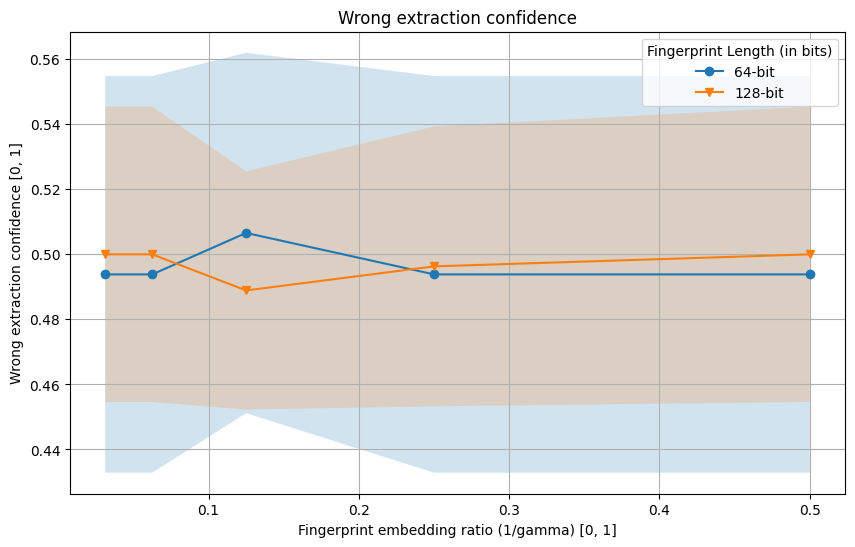

In [12]:
plot_tn_confidence(results)

## Fidelity 

The second requirement is fidelity, i.e. how preserved the data is. 

0. Accuracy (number of value differences)
1. Univariate statistics
2. Bi-variate stats

## Robustness

Robustness is measured by the resilience to the data modifications (attacks)
1. Independent attack: Robustness against flipping and subsetting attack
2. Independent attack: Background knowledge (maybe the correlation-knowing)
3. Collaboration attacks: Simple collusion
4. Collaboration attacks: Collusion with modifications

- Robustness stability: same attack, different fingerprinted datasets
- Robustness: same dataset, more randomised attacks

## Data utility

Data utility can be measured by the classification accuracy.